In [1]:
%matplotlib inline


Transfer Learning tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting this notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.  
    实际上，很少人会从随机初始化参数开始去训练一个完整的卷积神经网络，因为要找到满足的数据是十分罕见的。
    我们更常用的手段是先在一个很大的数据集上预训练一个卷积网络（比如 ImageNet，它包含1000类共12万张的图片），
    然后再利用这个网络作为初始网络去解决我们感兴趣的任务。

These two major transfer learning scenarios looks as follows:  
这是两种主要的 transfer learning 方案：

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.  
   **微调网络**：我们使用预训练的网络代替随机初始化网络。
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.  
   **卷积网络作为预调教好的特征提取器**：在这里，我们将冻结除了最后一层全连接层的所有的网络权值。
   这个最后一层全连接层要被一个新的随机初始化权值的网络层代替，我们也只将训练这一层网络。




In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.  
我们将使用 torchvision 包和 torch.utils.data 包来加载数据。

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.  
问题是我们今天将要训练的模型是分类**蚂蚁**和**蜜蜂**。我们只有大概每类120张供训练的图片。
通常意义上来讲，这是一个很小的数据集，如果我们要从随机初始化网络开始训练。要是使用 transfer learning
 的方法，我们应该有理由让这个模型很好地泛化。

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
# 加载并 Normalize 数据
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



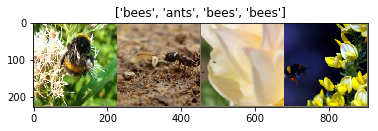

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:  
现在，让我们写一个一般地函数去训练一个模型，这里，我们将说明：

-  Scheduling the learning rate 制定学习速率
-  Saving the best model 保存最好的模型

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.  
LR scheduler 是个变学习率的一个算法。



In [5]:
# 定义一个训练模型，需要的提供的参数有：
# model，模型；criterion，误差定义算法；optimizer，优化器；scheduler，变学习速率算法；num_epoches，数据集循环循环次数
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [6]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

Finetuning the convnet  微调卷积网络
----------------------

Load a pretrained model and reset final fully connected layer.  
加载预训练模型并重置最后一层网络。




In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1375 Acc: 0.6885
val Loss: 0.0671 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.1157 Acc: 0.8115
val Loss: 0.0985 Acc: 0.8431

Epoch 2/24
----------
train Loss: 0.0938 Acc: 0.8402
val Loss: 0.0972 Acc: 0.8562

Epoch 3/24
----------
train Loss: 0.1319 Acc: 0.8033
val Loss: 0.0812 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.1493 Acc: 0.7910
val Loss: 0.1230 Acc: 0.8497

Epoch 5/24
----------
train Loss: 0.1203 Acc: 0.7910
val Loss: 0.1266 Acc: 0.8039

Epoch 6/24
----------
train Loss: 0.1182 Acc: 0.8484
val Loss: 0.0948 Acc: 0.8431

Epoch 7/24
----------
train Loss: 0.0847 Acc: 0.8730
val Loss: 0.0826 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.0737 Acc: 0.8852
val Loss: 0.0699 Acc: 0.8824

Epoch 9/24
----------
train Loss: 0.0706 Acc: 0.8770
val Loss: 0.0648 Acc: 0.8824

Epoch 10/24
----------
train Loss: 0.0822 Acc: 0.8689
val Loss: 0.0605 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.1016 Acc: 0.8156
val Loss: 0.0590 Acc: 0.9150

Ep

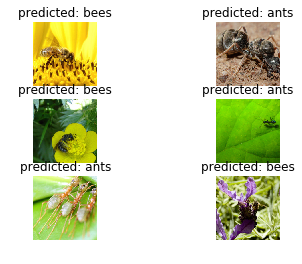

In [10]:
visualize_model(model_ft)

ConvNet as fixed feature extractor  卷积网络作为一个已预调的特征提取器
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.  
这里，我们需要冻结除最后一层之外的所有网络。我们需要令``require_grad == False``来冻结参数，使得自动反向传播不会在这些参数上计算。

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [11]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False    #跟上一种方案好像就多了这么一句话

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.  
在CPU上，对比前面的方案这将会耗费大约一半的时间。这是因为我们不需要再计算大部分网络的梯度，甚至前向计算都不再需要计算。




In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1841 Acc: 0.6189
val Loss: 0.0920 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.1177 Acc: 0.7623
val Loss: 0.0648 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.1079 Acc: 0.7869
val Loss: 0.0995 Acc: 0.8431

Epoch 3/24
----------
train Loss: 0.0923 Acc: 0.8238
val Loss: 0.0514 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.1008 Acc: 0.8361
val Loss: 0.0561 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.1126 Acc: 0.8197
val Loss: 0.0475 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.1079 Acc: 0.8320
val Loss: 0.0546 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.0886 Acc: 0.8484
val Loss: 0.0474 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.0760 Acc: 0.8730
val Loss: 0.0457 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.0804 Acc: 0.8525
val Loss: 0.0448 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.1075 Acc: 0.7951
val Loss: 0.0428 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.1105 Acc: 0.7951
val Loss: 0.0538 Acc: 0.9150

Ep

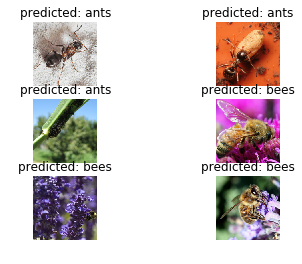

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()